# USE THIS FOR ENSEMBLE ---------------------------

In [85]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score,train_test_split, cross_val_predict
from sklearn.metrics import mean_squared_error,r2_score, roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, ParameterGrid, RandomizedSearchCV
from sklearn.ensemble import BaggingRegressor,BaggingClassifier,RandomForestRegressor,RandomForestClassifier
import itertools as it

In [86]:
data = pd.read_csv('movies_classification_updated.csv', index_col='Unnamed: 0')

In [87]:
y = data.revenue
X = data.drop(['revenue', 'title'], axis = 1)

In [88]:
# splitting test/train data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 45)

Not scaling the data: Decision trees and ensemble methods do not require feature scaling to be performed as they are not sensitive to the the variance in the data.

In [89]:
X_train.shape

(35756, 26)

In [90]:
# making base model to find the range of hyperparameters
model = DecisionTreeClassifier(random_state = 1)
model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=1)

In [91]:
# accuracy/recall without tuning
pred=model.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.8578299776286353
recall: 0.5959944751381215
Precision:  0.5571336346029696


In [92]:
# finding range of hyperparameters
print("Maximum tree depth =", model.get_depth())
print("Maximum leaves =", model.get_n_leaves())

Maximum tree depth = 34
Maximum leaves = 4737


In [93]:
# coarse grid search
parameters = {'max_depth':range(2,34, 5),
              'max_leaf_nodes':range(2, 4737, 100), 
              'max_features': range(1, 26, 5)}

cv = KFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring='precision')

grid_result.fit(X_train, y_train)

Fitting 5 folds for each of 1680 candidates, totalling 8400 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=1, shuffle=True),
             estimator=DecisionTreeClassifier(random_state=1), n_jobs=-1,
             param_grid={'max_depth': range(2, 34, 5),
                         'max_features': range(1, 26, 5),
                         'max_leaf_nodes': range(2, 4737, 100)},
             scoring='precision', verbose=1)

In [94]:
print(grid_result.best_score_, grid_result.best_params_) 

0.7764919330314938 {'max_depth': 12, 'max_features': 16, 'max_leaf_nodes': 102}


In [95]:
pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_max_leaf_nodes,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
625,0.085410,0.009345,0.010340,0.000522,12,16,102,"{'max_depth': 12, 'max_features': 16, 'max_lea...",0.772384,0.776879,0.792193,0.766147,0.774857,0.776492,0.008640,1
673,0.114472,0.003087,0.014435,0.002715,12,21,102,"{'max_depth': 12, 'max_features': 21, 'max_lea...",0.773987,0.769492,0.794151,0.777650,0.767033,0.776462,0.009570,2
433,0.100379,0.011444,0.010704,0.000807,7,21,102,"{'max_depth': 7, 'max_features': 21, 'max_leaf...",0.795139,0.767666,0.789766,0.761242,0.761905,0.775144,0.014409,3
865,0.089198,0.006311,0.011000,0.000316,17,16,102,"{'max_depth': 17, 'max_features': 16, 'max_lea...",0.770140,0.781503,0.790564,0.765419,0.767494,0.775024,0.009553,4
1345,0.145757,0.008567,0.019091,0.001843,27,16,102,"{'max_depth': 27, 'max_features': 16, 'max_lea...",0.770140,0.781503,0.790564,0.765419,0.767494,0.775024,0.009553,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
46,0.024113,0.003519,0.018368,0.007098,2,1,4602,"{'max_depth': 2, 'max_features': 1, 'max_leaf_...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1613
47,0.025774,0.003965,0.013762,0.002303,2,1,4702,"{'max_depth': 2, 'max_features': 1, 'max_leaf_...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1613
48,0.030916,0.002674,0.013129,0.002993,2,6,2,"{'max_depth': 2, 'max_features': 6, 'max_leaf_...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1613
42,0.024264,0.002318,0.014410,0.003829,2,1,4202,"{'max_depth': 2, 'max_features': 1, 'max_leaf_...",0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1613


In [104]:
model = DecisionTreeClassifier(random_state = 1, max_depth= 12, max_features = 16, max_leaf_nodes = 102)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, max_features=16, max_leaf_nodes=102,
                       random_state=1)

In [105]:
# accuracy/recall
pred=model.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.9052572706935123
recall: 0.5904696132596685
Precision:  0.7709648331830478


With the hyperparameters tuned based on maximizing precision, the precision has increased by 20%, the accuracy by 3%, and the recall has decrease by 10%. Let's do a finer grid search focused on precision and plot the precision-accuracy curve to find the optimal hyperparameters. I also need to find the optimal decision threshold probability.

In [106]:
# finer grid search
parameters = {'max_depth':range(7,17, 2),
              'max_leaf_nodes':range(90, 300, 25), 
              'max_features': range(16, 29, 2)}

cv = KFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = GridSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring='precision')

grid_result.fit(X_train, y_train)
print (grid_result.best_score_, grid_result.best_params_) 

Fitting 5 folds for each of 315 candidates, totalling 1575 fits
0.7836584372111675 {'max_depth': 9, 'max_features': 20, 'max_leaf_nodes': 140}


In [107]:
model = DecisionTreeClassifier(random_state = 1, max_depth= 9, max_features = 20, max_leaf_nodes = 140)
model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=9, max_features=20, max_leaf_nodes=140,
                       random_state=1)

In [108]:
# accuracy/recall
pred=model.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.9059284116331097
recall: 0.6022099447513812
Precision:  0.7669305189094108


NOPE FIX THOS: With the finer grid search parameters, the accuracy stayed about the same, the recall dropped about 10%, and the precision increased by almost 10%. 

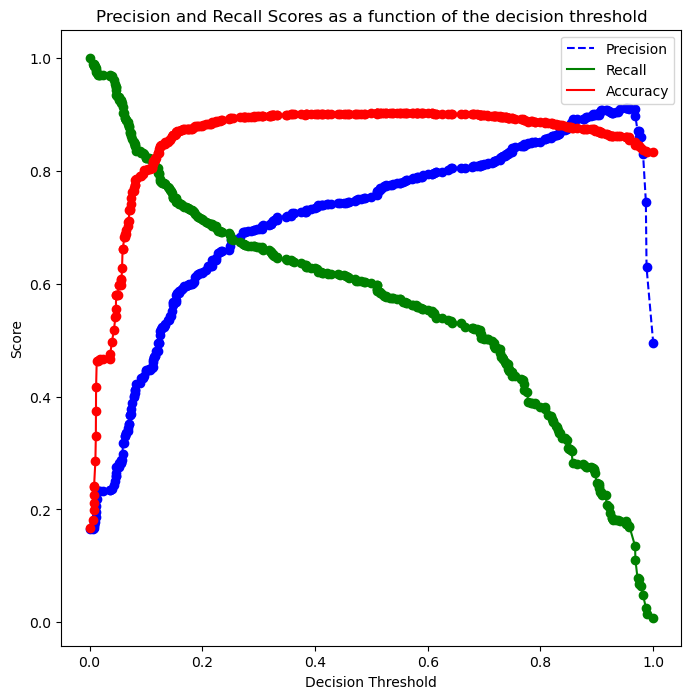

In [109]:
# Note that we are using the cross-validated predicted probabilities, instead of directly using the 
# predicted probabilities on train data, as the model may be overfitting on the train data, and 
# may lead to misleading results

cross_val_ypred = cross_val_predict(model, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [110]:
all_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})

In [112]:
all_thresholds.sort_values('precision', ascending=False)

,thresholds,precision,recall,accuracy
333,0.957895,0.911232,0.169332,0.854094
330,0.952381,0.911170,0.174381,0.859968
331,0.953125,0.911092,0.174213,0.859520
329,0.951923,0.911035,0.179263,0.859996
332,0.957447,0.909821,0.171520,0.859240
...,...,...,...,...
4,0.007812,0.172422,0.986703,0.225417
3,0.007186,0.170296,0.987376,0.210902
2,0.006957,0.167480,0.988217,0.198596
0,0.000000,0.166154,1.000000,0.166797


Accuracy:  0.8583454525114667
ROC-AUC:  0.9083850382639302
Precision:  0.9781659388646288
Recall:  0.1508163608820064


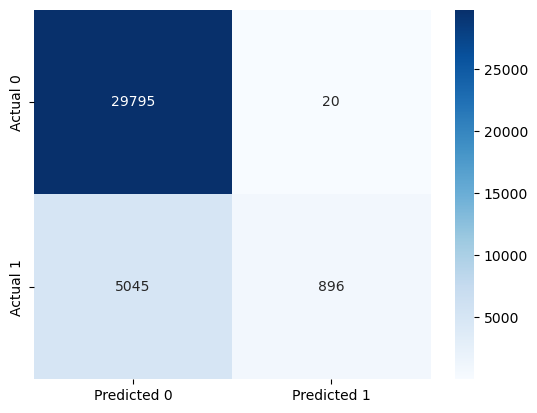

In [113]:
#Performance metrics computation for the optimum decision threshold probability - training data
desired_threshold = 0.957895
#choosing this threshold bc it has a very high accuracy and precision both around 88%

y_pred_prob = model.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Test Accuracy:  0.858165548098434
Test ROC-AUC:  0.8977130393967192
Test Precision:  0.9326923076923077
Test Recall:  0.13397790055248618


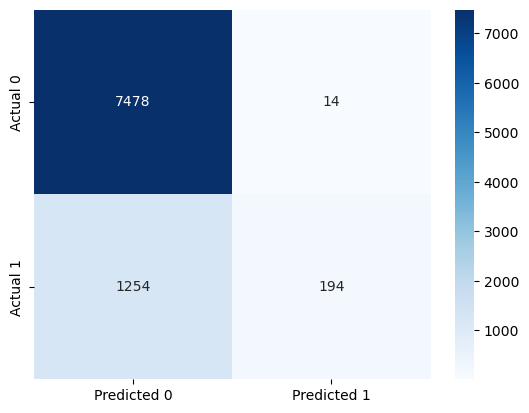

In [114]:
#Performance metrics computation for the optimum decision threshold probability - test data
y_pred_prob = model.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("Test ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

# STOP HERE FOR ENSEMBLE ---------------------------

# Cost Complexity Pruning
While optimizing parameters above, we optimized them within a range that we thought was reasonable. While doing so, we restricted ourselves to considering only a subset of the unpruned tree. Thus, we could have missed out on finding the optimal tree (or the best model).

With cost complexity pruning, we first develop an unpruned tree without any restrictions. Then, using cross validation, we find the optimal value of the tuning parameter 


In [26]:
model = DecisionTreeClassifier(random_state = 1) #model without any restrictions
path= model.cost_complexity_pruning_path(X_train,y_train) # Compute the pruning path during Minimal Cost-Complexity Pruning.

In [27]:
alphas=path['ccp_alphas']
len(alphas)

1420

In [35]:
#Grid search to optimize parameter values

skf = StratifiedKFold(n_splits=5)
grid_search = GridSearchCV(DecisionTreeClassifier(random_state = 1), param_grid = {'ccp_alpha':alphas}, 
                                                  scoring=['precision','recall','accuracy'], 
                                                  refit="precision", cv=skf, n_jobs=-1, verbose = True)
grid_search.fit(X_train, y_train)

# make the predictions
y_pred = grid_search.predict(X_test)

print('Best params for precision')
print(grid_search.best_params_)

Fitting 5 folds for each of 1420 candidates, totalling 7100 fits
Best params for recall
{'ccp_alpha': 0.0013034274896670112}


In [36]:
optimal_alpha =0.0013034274896670112

In [37]:
# Model with the optimal value of 'ccp_alpha'
model_w_alpha = DecisionTreeClassifier(ccp_alpha=optimal_alpha,random_state=1)
model_w_alpha.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0013034274896670112, random_state=1)

In [38]:
# accuracy/recall
pred=model_w_alpha.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.9073825503355705
recall: 0.5511049723756906
Precision:  0.8176229508196722


Here, our accuracy is about the same, recall is slightly higher, but precision has dropped by about 10%.

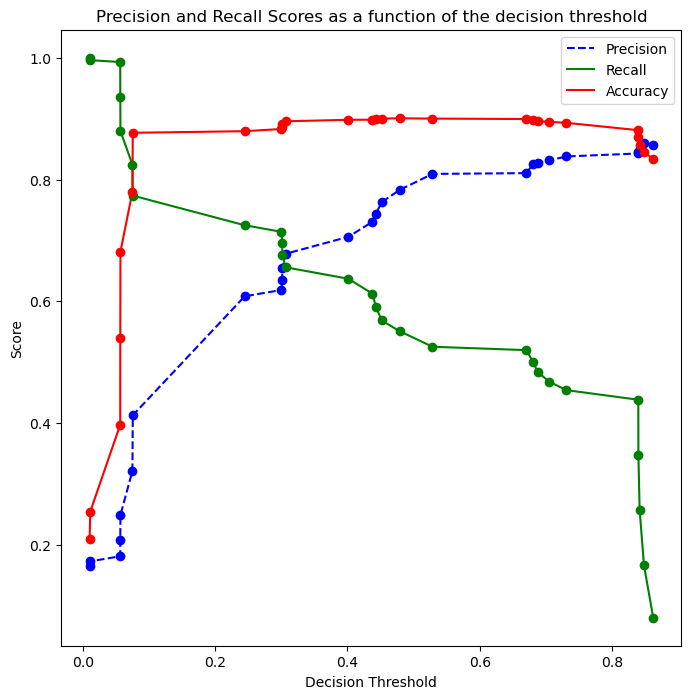

In [39]:
# finding decision threshold prob

cross_val_ypred = cross_val_predict(model_w_alpha, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [42]:
all_alpha_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_alpha_thresholds.sort_values('precision', ascending=False)

,thresholds,precision,recall,accuracy
26,0.848161,0.860243,0.166807,0.845005
27,0.862155,0.856887,0.080626,0.833846
25,0.841608,0.848367,0.258037,0.857059
24,0.839734,0.844771,0.348090,0.869057
23,0.839608,0.842769,0.438478,0.881055
22,0.730845,0.837939,0.454301,0.893109
21,0.705104,0.831390,0.468103,0.894731
20,0.687500,0.827815,0.483925,0.895850
19,0.681051,0.825640,0.499748,0.897528
18,0.670227,0.810548,0.519946,0.899346


choosing the threshold with index 22

Accuracy:  0.8943394115672894
ROC-AUC:  0.8337047488294183
Precision:  0.8387096774193549
Recall:  0.45076586433260396


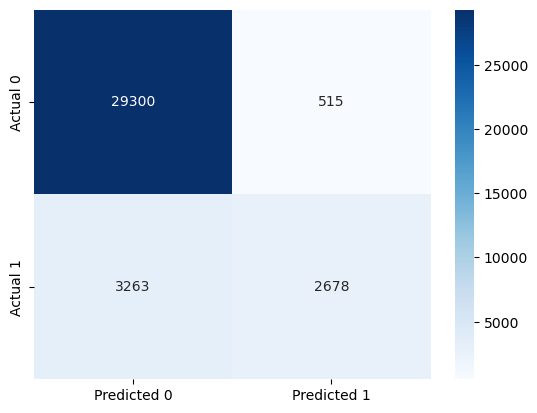

In [43]:
#Performance metrics computation for the optimum decision threshold probability - training data
desired_threshold = 0.730845
#choosing this threshold bc it has a very high accuracy and precision both around 88%

y_pred_prob = model_w_alpha.predict_proba(X_train)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Accuracy: ",accuracy_score(y_pred, y_train))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_train, y_pred_prob)
print("ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Precision: ", precision_score(y_train, y_pred))
print("Recall: ", recall_score(y_train, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_train, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

Test Accuracy:  0.8992170022371365
Test ROC-AUC:  0.8410819146315922
Test Precision:  0.8457648546144121
Test Recall:  0.4620165745856354


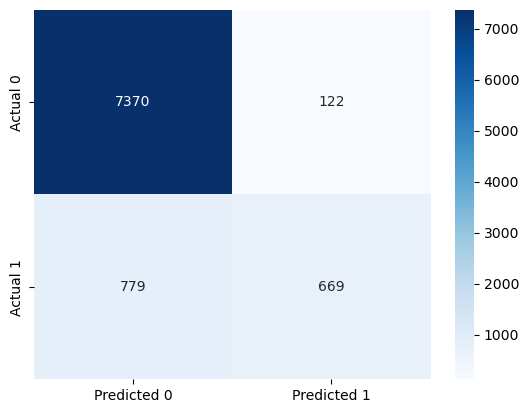

In [44]:
#Performance metrics computation for the optimum decision threshold probability - test data
y_pred_prob = model_w_alpha.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("Test ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))

#Confusion matrix
cm = pd.DataFrame(confusion_matrix(y_test, y_pred), 
                  columns=['Predicted 0', 'Predicted 1'], index = ['Actual 0', 'Actual 1'])
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g');

This model has a lower accuracy, lower precision, and only slightly higher recall. Since we are trying to optimize precision, i will try to combine the cost complexity pruning as well as tuning other hyperparameters to see if this improves the precision.

# pruned model with tuned hyperparameters and

In [59]:
parameters = {'max_depth':range(2,34, 5),
              'max_leaf_nodes':range(2, 4737, 100), 
              'max_features': range(1, 26, 5),
              'ccp_alpha':alphas}

cv = KFold(n_splits = 5,shuffle=True,random_state=1)

grid_result = RandomizedSearchCV(DecisionTreeClassifier(random_state=1), parameters, n_jobs=-1,verbose=1,cv=cv,
                    scoring="precision")

grid_result.fit(X_train, y_train)
print (grid_result.best_score_, grid_result.best_params_) 

Fitting 5 folds for each of 10 candidates, totalling 50 fits
0.7520968242674874 {'max_leaf_nodes': 402, 'max_features': 6, 'max_depth': 32, 'ccp_alpha': 1.3532581042116992e-05}


In [61]:
pd.DataFrame(grid_result.cv_results_).sort_values('rank_test_score')

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_leaf_nodes,param_max_features,param_max_depth,param_ccp_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,0.066199,0.009119,0.011014,0.002029,402,6,32,0.000014,"{'max_leaf_nodes': 402, 'max_features': 6, 'ma...",0.763307,0.739659,0.764045,0.760369,0.733104,0.752097,0.013056,1
2,0.126792,0.016757,0.010033,0.000812,3302,16,12,0.000048,"{'max_leaf_nodes': 3302, 'max_features': 16, '...",0.761478,0.743619,0.744518,0.752723,0.738122,0.748092,0.008159,2
3,0.100749,0.009939,0.012111,0.002401,502,16,27,0.00004,"{'max_leaf_nodes': 502, 'max_features': 16, 'm...",0.757642,0.718947,0.771234,0.749175,0.729167,0.745233,0.018945,3
7,0.076928,0.012641,0.016620,0.010589,1002,6,12,0.000037,"{'max_leaf_nodes': 1002, 'max_features': 6, 'm...",0.761905,0.726363,0.756312,0.737010,0.730519,0.742422,0.014152,4
8,0.041045,0.006553,0.015250,0.010317,2602,16,2,0.000075,"{'max_leaf_nodes': 2602, 'max_features': 16, '...",0.713352,0.710704,0.748266,0.712107,0.711089,0.719104,0.014610,5
1,0.035390,0.005151,0.009404,0.000805,902,1,32,0.000042,"{'max_leaf_nodes': 902, 'max_features': 1, 'ma...",0.750769,0.678771,0.749311,0.734615,0.657210,0.714135,0.038704,6
9,0.029053,0.004421,0.008995,0.004497,2402,1,12,0.000032,"{'max_leaf_nodes': 2402, 'max_features': 1, 'm...",0.733157,0.716263,0.750000,0.683353,0.681452,0.712845,0.027056,7
4,0.046306,0.006179,0.012377,0.003077,2202,1,27,0.000027,"{'max_leaf_nodes': 2202, 'max_features': 1, 'm...",0.722838,0.643068,0.683180,0.713772,0.659677,0.684507,0.030533,8
6,0.077467,0.010526,0.014537,0.007328,4602,1,27,0.000029,"{'max_leaf_nodes': 4602, 'max_features': 1, 'm...",0.657216,0.640000,0.691299,0.694836,0.653753,0.667421,0.021747,9
0,0.122926,0.003615,0.011804,0.002468,4002,11,32,0.000023,"{'max_leaf_nodes': 4002, 'max_features': 11, '...",0.613699,0.604630,0.611668,0.624210,0.584821,0.607806,0.013093,10


In [64]:
model_combined = DecisionTreeClassifier(ccp_alpha=1.3532581042116992e-05,random_state=1, max_leaf_nodes=402, max_features=6, max_depth=32)
model_combined.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=1.3532581042116992e-05, max_depth=32,
                       max_features=6, max_leaf_nodes=402, random_state=1)

In [67]:
# accuracy/recall
pred=model_combined.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.8968680089485459
recall: 0.5752762430939227
Precision:  0.730701754385965


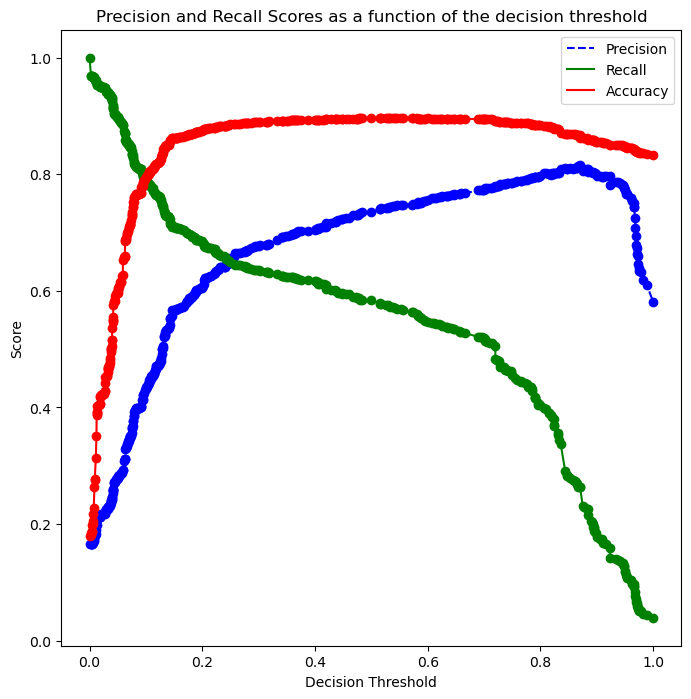

In [76]:
# finding decision threshold prob

cross_val_ypred = cross_val_predict(model_combined, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [78]:
all_alpha_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_alpha_thresholds.sort_values('precision', ascending=False).head(20)

,thresholds,precision,recall,accuracy
402,0.870288,0.815336,0.263087,0.862932
401,0.869565,0.814256,0.263424,0.867659
400,0.866667,0.814123,0.263929,0.867631
399,0.865169,0.812532,0.268473,0.867687
398,0.864865,0.811168,0.268978,0.868162
391,0.843750,0.810976,0.291028,0.869924
397,0.863636,0.810553,0.271503,0.868134
396,0.860759,0.810259,0.273860,0.868414
394,0.851852,0.809942,0.279751,0.868833
392,0.846154,0.809798,0.283791,0.869672


In [116]:
desired_threshold = 0.870288
y_pred_prob = model_combined.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("Test ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))

Test Accuracy:  0.866331096196868
Test ROC-AUC:  0.8585481050874155
Test Precision:  0.8302872062663186
Test Recall:  0.21961325966850828


None of these combinations are as good as previous ones.

# Pruned model combined with hyperparameters optimized separately

In [120]:
model_combined_2 = DecisionTreeClassifier(random_state = 1, max_depth= 2, max_features = 28, max_leaf_nodes = 2000, ccp_alpha=optimal_alpha)
model_combined_2.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0013034274896670112, max_depth=2,
                       max_features=28, max_leaf_nodes=2000, random_state=1)

In [121]:
# accuracy/recall
pred=model_combined_2.predict(X_test)
print('accuracy:', accuracy_score(y_test, pred))
print('recall:', recall_score(y_test, pred))
print("Precision: ", precision_score(y_test, pred))

accuracy: 0.9002237136465324
recall: 0.6429558011049724
Precision:  0.7128637059724349


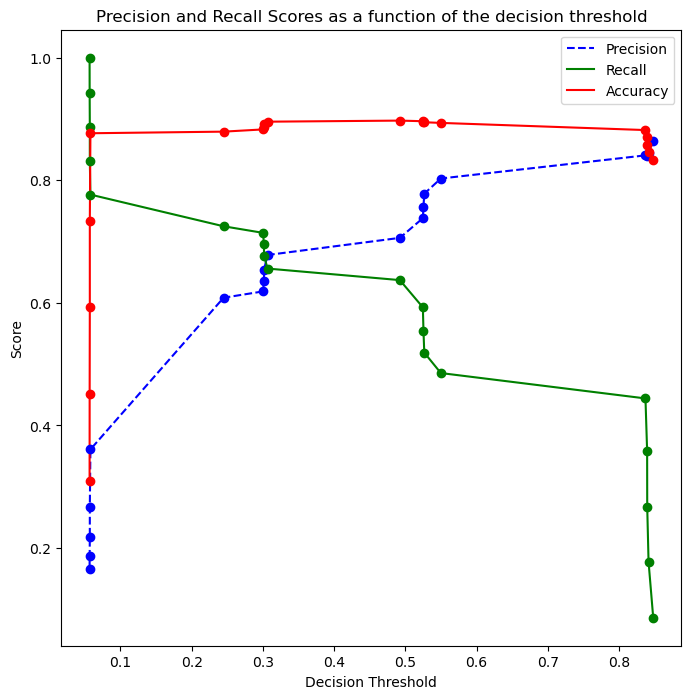

In [122]:
# finding decision threshold prob

cross_val_ypred = cross_val_predict(model_combined_2, X_train, y_train, cv = 5, method = 'predict_proba')

p, r, thresholds = precision_recall_curve(y_train, cross_val_ypred[:,1])
acc = np.ndarray(shape = (len(thresholds),))
i = 0
for th in thresholds:
    y_pred = cross_val_ypred[:,1] > th
    y_pred = y_pred.astype(int)
    acc[i] = accuracy_score(y_pred, y_train)
    i = i + 1
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.plot(thresholds, acc, "r-", label="Accuracy")
    plt.plot(thresholds, precisions[:-1], "o", color = 'blue')
    plt.plot(thresholds, recalls[:-1], "o", color = 'green')
    plt.plot(thresholds, acc, "o", color = 'red')
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')
    plt.legend()
plot_precision_recall_vs_threshold(p, r, thresholds)

In [123]:
all_alpha_thresholds = pd.DataFrame({'thresholds': thresholds, 
                           'precision': p[:-1],
                           'recall': r[:-1],
                           'accuracy': acc})
all_alpha_thresholds.sort_values('precision', ascending=False)

,thresholds,precision,recall,accuracy
19,0.848161,0.863406,0.086181,0.833846
18,0.841608,0.844551,0.177411,0.845900
17,0.839734,0.841186,0.267463,0.857898
15,0.837263,0.840663,0.444033,0.881950
16,0.839608,0.839652,0.357852,0.869896
14,0.549889,0.802895,0.485440,0.893640
13,0.526638,0.778086,0.518768,0.894703
12,0.525498,0.757011,0.554284,0.895458
11,0.524652,0.738155,0.592661,0.896381
10,0.492329,0.706025,0.637098,0.897388


In [124]:
desired_threshold = 0.848161
y_pred_prob = model_combined_2.predict_proba(X_test)[:,1] 

# Classifying observations in the positive class (y = 1) if the predicted probability is greater
# than the desired decision threshold probability
y_pred = y_pred_prob > desired_threshold
y_pred = y_pred.astype(int)

#Computing the accuracy
print("Test Accuracy: ",accuracy_score(y_pred, y_test))  

#Computing the ROC-AUC
fpr, tpr, auc_thresholds = roc_curve(y_test, y_pred_prob)
print("Test ROC-AUC: ",auc(fpr, tpr))# AUC of ROC

#Computing the precision and recall
print("Test Precision: ", precision_score(y_test, y_pred))
print("Test Recall: ", recall_score(y_test, y_pred))

Test Accuracy:  0.8380313199105145
Test ROC-AUC:  0.8402539135667363
Test Precision:  0.0
Test Recall:  0.0


C:\Users\csky2\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


These are also worse. The best model is just the tuned hyperparameter one